In [78]:
import os
import shutil
import random
from pathlib import Path
from collections import Counter
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image



In [79]:
# Config
BASE = Path("Dataset")
OUT = Path("Dataset_filtered")
TOP_K = 8
SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS = 20
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


#Selecting top_k classes
all_class_dirs = [d for d in BASE.iterdir() if d.is_dir() and d.name not in ["train","val","test"]]
counts = {d.name: len(list(d.glob("*"))) for d in all_class_dirs}
sorted_by_count = sorted(counts.items(), key=lambda x: x[1], reverse=True)
print("Found classes and counts (top 20):")
for name, c in sorted_by_count[:20]:
    print(f"  {name:40s} : {c}")

top_classes = [name for name, c in sorted_by_count[:TOP_K]]
print(f"\nKeeping top {TOP_K} classes:\n", top_classes)


# filtered dataset structure, splited 70/15/15
for split in ["train","val","test"]:
    (OUT / split).mkdir(parents=True, exist_ok=True)

for cls in top_classes:
    src = BASE / cls
    images = list(src.glob("*"))
    if len(images) == 0:
        continue
    random.shuffle(images)
    n = len(images)
    n_train = int(0.7 * n)
    n_val = int(0.15 * n)
    # create dest folders
    (OUT / "train" / cls).mkdir(parents=True, exist_ok=True)
    (OUT / "val" / cls).mkdir(parents=True, exist_ok=True)
    (OUT / "test" / cls).mkdir(parents=True, exist_ok=True)
    # copy
    for p in images[:n_train]:
        shutil.copy(p, OUT / "train" / cls / p.name)
    for p in images[n_train:n_train+n_val]:
        shutil.copy(p, OUT / "val" / cls / p.name)
    for p in images[n_train+n_val:]:
        shutil.copy(p, OUT / "test" / cls / p.name)

print("Filtered dataset created at", OUT)

Device: cuda
Found classes and counts (top 20):
  Tomato__Tomato_YellowLeaf__Curl_Virus    : 3209
  Tomato_Bacterial_spot                    : 2127
  Apple___Apple_scab                       : 2016
  Apple___healthy                          : 2008
  Apple___Black_rot                        : 1987
  Tomato_Late_blight                       : 1909
  Corn_(maize)___Northern_Leaf_Blight      : 1908
  Corn_(maize)___Common_rust_              : 1907
  Corn_(maize)___healthy                   : 1859
  Tomato_Septoria_leaf_spot                : 1771
  Apple___Cedar_apple_rust                 : 1760
  Tomato_Spider_mites_Two_spotted_spider_mite : 1676
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 1642
  Tomato_healthy                           : 1591
  Pepper__bell___healthy                   : 1478
  Tomato__Target_Spot                      : 1404
  Potato___Early_blight                    : 1000
  Potato___Late_blight                     : 1000
  Tomato_Early_blight                  

In [80]:
# Transforms, Datasets, DataLoaders
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(OUT / "train", transform=train_transform)
val_dataset = datasets.ImageFolder(OUT / "val", transform=val_transform)
test_dataset = datasets.ImageFolder(OUT / "test", transform=val_transform)

classes = train_dataset.classes
num_classes = len(classes)
print("Classes used:", classes)
print("Num classes:", num_classes)

# Weighted sampler (на случай, если внутри топ-к все равно есть дисбаланс)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.arange(num_classes),
                                     y=train_dataset.targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
sample_weights = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

Classes used: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Num classes: 8


In [81]:
#Model (CustomCNN with BatchNorm)
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)

        with torch.no_grad():
            dummy = torch.zeros(1,3,224,224)
            x = self.pool(F.relu(self.bn1(self.conv1(dummy))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            flatten_dim = x.numel()

        self.fc1 = nn.Linear(flatten_dim, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x))); x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x))); x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x))); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)


In [82]:
#Training loop (mixed precision)
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

best_val_acc = 0.0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for images, labels in tqdm(train_loader, desc=f"Train epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    train_losses.append(epoch_loss); train_accs.append(epoch_acc)

    # validation
    model.eval()
    val_loss_total, val_corrects = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)
            preds = torch.argmax(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
    val_loss = val_loss_total / len(val_dataset)
    val_acc = val_corrects / len(val_dataset)
    val_losses.append(val_loss); val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}  Train Loss={epoch_loss:.4f} Acc={epoch_acc:.4f}  Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_filtered.pth")
        print("[INFO] Saved best_model_filtered.pth")


C:\Users\Tensa\AppData\Local\Temp\ipykernel_11988\172126783.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Train epoch 1/20:   0%|          | 0/374 [00:00<?, ?it/s]C:\Users\Tensa\AppData\Local\Temp\ipykernel_11988\172126783.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Train epoch 1/20: 100%|██████████| 374/374 [01:39<00:00,  3.74it/s]


Epoch 1/20  Train Loss=3.3993 Acc=0.3963  Val Loss=0.8931 Acc=0.7061
[INFO] Saved best_model_filtered.pth


Train epoch 2/20: 100%|██████████| 374/374 [01:18<00:00,  4.79it/s]


Epoch 2/20  Train Loss=1.3116 Acc=0.4905  Val Loss=0.7231 Acc=0.7386
[INFO] Saved best_model_filtered.pth


Train epoch 3/20: 100%|██████████| 374/374 [01:12<00:00,  5.18it/s]


Epoch 3/20  Train Loss=1.2217 Acc=0.5224  Val Loss=0.7463 Acc=0.6757


Train epoch 4/20: 100%|██████████| 374/374 [01:09<00:00,  5.41it/s]


Epoch 4/20  Train Loss=1.1400 Acc=0.5582  Val Loss=0.5878 Acc=0.7444
[INFO] Saved best_model_filtered.pth


Train epoch 5/20: 100%|██████████| 374/374 [01:07<00:00,  5.51it/s]


Epoch 5/20  Train Loss=1.1008 Acc=0.5742  Val Loss=0.5619 Acc=0.8558
[INFO] Saved best_model_filtered.pth


Train epoch 6/20: 100%|██████████| 374/374 [01:06<00:00,  5.66it/s]


Epoch 6/20  Train Loss=1.0808 Acc=0.5728  Val Loss=0.5154 Acc=0.8156


Train epoch 7/20: 100%|██████████| 374/374 [01:09<00:00,  5.36it/s]


Epoch 7/20  Train Loss=0.9888 Acc=0.6132  Val Loss=0.5253 Acc=0.8496


Train epoch 8/20: 100%|██████████| 374/374 [01:06<00:00,  5.61it/s]


Epoch 8/20  Train Loss=0.9964 Acc=0.6060  Val Loss=0.4629 Acc=0.8382


Train epoch 9/20: 100%|██████████| 374/374 [01:09<00:00,  5.35it/s]


Epoch 9/20  Train Loss=0.9447 Acc=0.6269  Val Loss=0.3891 Acc=0.8492


Train epoch 10/20: 100%|██████████| 374/374 [01:08<00:00,  5.49it/s]


Epoch 10/20  Train Loss=0.9122 Acc=0.6438  Val Loss=0.3649 Acc=0.8964
[INFO] Saved best_model_filtered.pth


Train epoch 11/20: 100%|██████████| 374/374 [01:08<00:00,  5.44it/s]


Epoch 11/20  Train Loss=0.8980 Acc=0.6496  Val Loss=0.4307 Acc=0.8394


Train epoch 12/20: 100%|██████████| 374/374 [01:07<00:00,  5.55it/s]


Epoch 12/20  Train Loss=0.8420 Acc=0.6682  Val Loss=0.3513 Acc=0.9007
[INFO] Saved best_model_filtered.pth


Train epoch 13/20: 100%|██████████| 374/374 [01:04<00:00,  5.81it/s]


Epoch 13/20  Train Loss=0.8233 Acc=0.6746  Val Loss=0.2813 Acc=0.9285
[INFO] Saved best_model_filtered.pth


Train epoch 14/20: 100%|██████████| 374/374 [01:04<00:00,  5.81it/s]


Epoch 14/20  Train Loss=0.7941 Acc=0.6844  Val Loss=0.3767 Acc=0.8761


Train epoch 15/20: 100%|██████████| 374/374 [01:05<00:00,  5.71it/s]


Epoch 15/20  Train Loss=0.7826 Acc=0.6909  Val Loss=0.2896 Acc=0.9047


Train epoch 16/20: 100%|██████████| 374/374 [01:05<00:00,  5.74it/s]


Epoch 16/20  Train Loss=0.7525 Acc=0.7030  Val Loss=0.2868 Acc=0.9195


Train epoch 17/20: 100%|██████████| 374/374 [01:20<00:00,  4.62it/s]


Epoch 17/20  Train Loss=0.7327 Acc=0.7072  Val Loss=0.2475 Acc=0.9140


Train epoch 18/20: 100%|██████████| 374/374 [01:18<00:00,  4.78it/s]


Epoch 18/20  Train Loss=0.7178 Acc=0.7123  Val Loss=0.2071 Acc=0.9574
[INFO] Saved best_model_filtered.pth


Train epoch 19/20: 100%|██████████| 374/374 [01:18<00:00,  4.78it/s]


Epoch 19/20  Train Loss=0.6854 Acc=0.7286  Val Loss=0.1697 Acc=0.9562


Train epoch 20/20: 100%|██████████| 374/374 [01:17<00:00,  4.81it/s]


Epoch 20/20  Train Loss=0.6498 Acc=0.7394  Val Loss=0.2773 Acc=0.9168


C:\Users\Tensa\AppData\Local\Temp\ipykernel_11988\2424775521.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_filtered.pth'))

                                       precision    recall  f1-score   support

                   Apple___Apple_scab       0.93      0.96      0.94       303
                    Apple___Black_rot       0.95      1.00      0.97       299
                      Apple___healthy       0.99      0.93      0.96       302
          Corn_(maize)___Common_rust_       1.00      0.98      0.99       287
  Corn_(maize)___Northern_Leaf_Blight       0.99      1.00      0.99       287
                Tomato_Bacterial_spot       0.89      0.93      0.91       320
                   Tomato_Late_blight       0.93      0.95      0.94       287
Tomato__Tomato_YellowLeaf__Curl_Virus       0.98      0.93      0.95       482

                             accuracy                           0.96      2567
                            macro avg       0.96      0.96      0.96      2567
                         weighted avg       0.96      0.96      0.96      2567



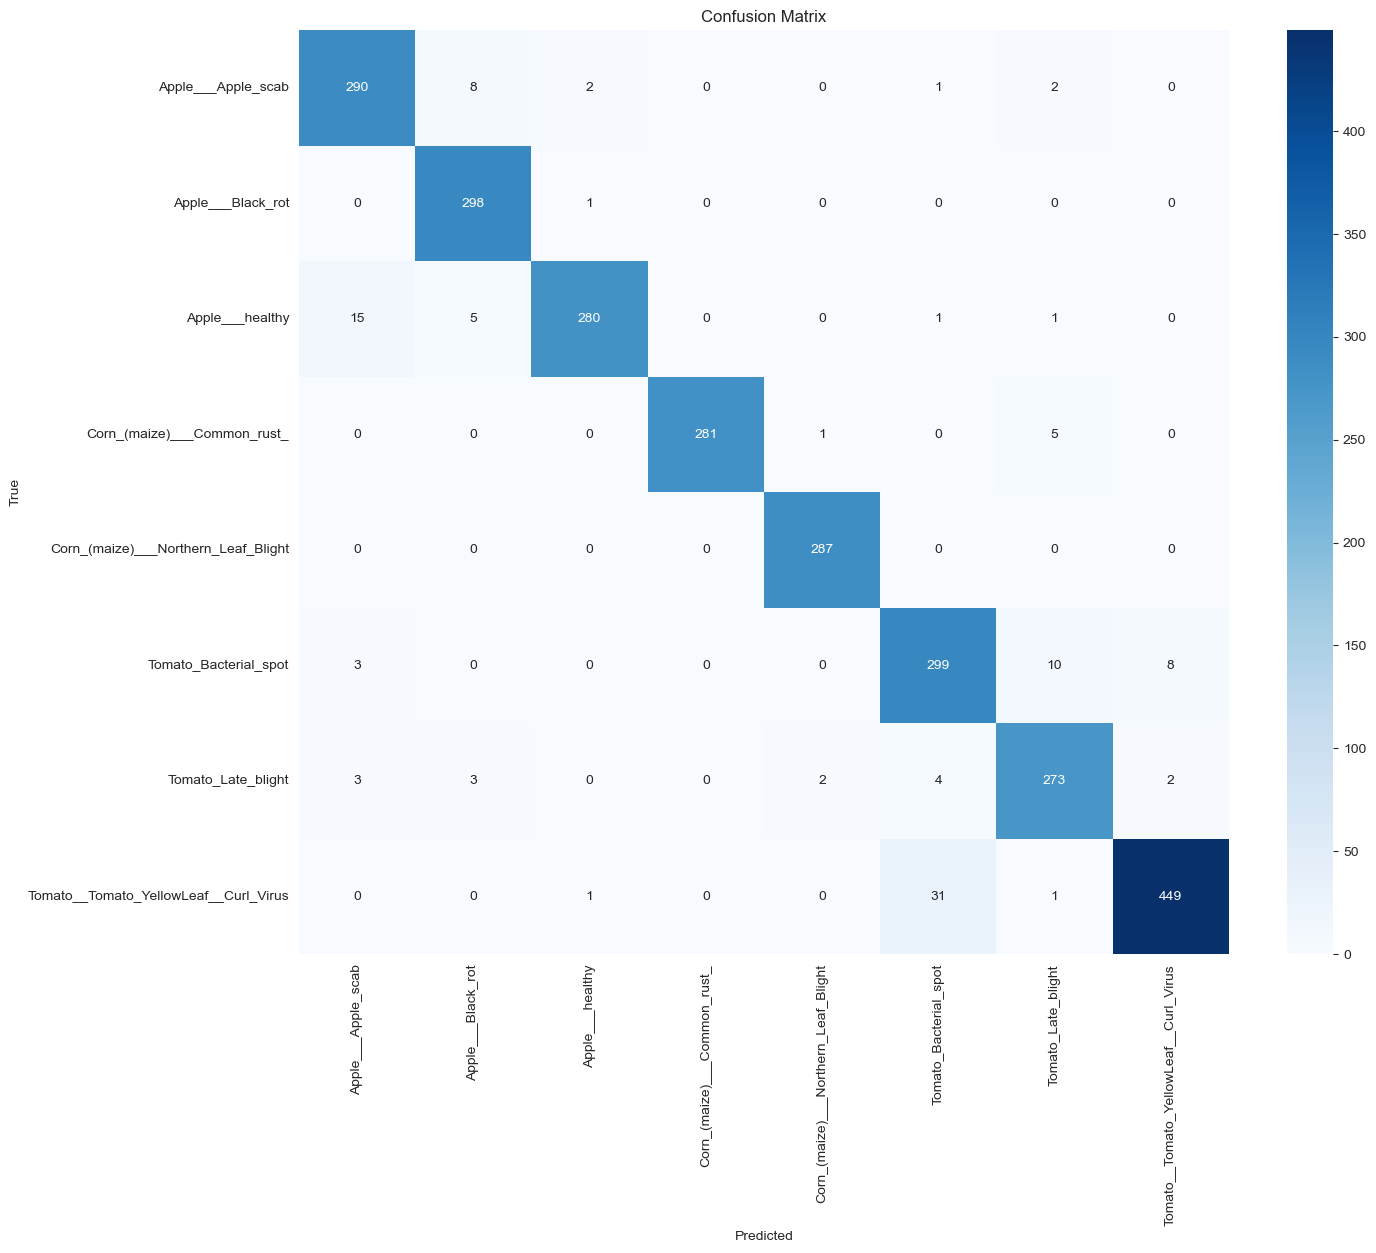

In [86]:
#Test Metrics
model.load_state_dict(torch.load('best_model_filtered.pth'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [97]:
from PIL import Image

def predict_image(image_path, model, transform, classes):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, 1).item()
    return classes[pred]

# Example usage
sample_image = 'Dataset/Corn_(maize)___Common_rust_/RS_Rust 1646.JPG'
prediction = predict_image(sample_image, model, val_transform, classes)
print(f"Predicted class: {prediction}")


Predicted class: Corn_(maize)___Common_rust_


In [95]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

# Трансформация без аугментаций
clean_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Путь к train-папке (та, где лежат только top-K классы)
train_dir = "Dataset_filtered/train"

# Создаем датасет
train_dataset_clean = ImageFolder(root=train_dir, transform=clean_transform)


print("Classes in dataset:", train_dataset_clean.classes)


Classes in dataset: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [96]:
from collections import defaultdict
model.eval()
per_class = defaultdict(lambda: [0,0])  # [correct, total]
with torch.no_grad():
    for imgs, labels in DataLoader(train_dataset_clean, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(1)
        for p, t in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            per_class[t][1] += 1
            if p == t: per_class[t][0] += 1

for idx, (corr, tot) in per_class.items():
    print(idx, classes[idx], corr / tot)


0 Apple___Apple_scab 0.9447200566973778
1 Apple___Black_rot 0.9964028776978417
2 Apple___healthy 0.9238434163701068
3 Corn_(maize)___Common_rust_ 0.992503748125937
4 Corn_(maize)___Northern_Leaf_Blight 0.998501872659176
5 Tomato_Bacterial_spot 0.9065860215053764
6 Tomato_Late_blight 0.9520958083832335
7 Tomato__Tomato_YellowLeaf__Curl_Virus 0.9367483296213809


F1-scores per class: [0.94462541 0.97226754 0.9556314  0.98943662 0.99480069 0.91158537
 0.94300518 0.95430393]
Precision per class: [0.93247588 0.94904459 0.98591549 1.         0.98965517 0.88988095
 0.93493151 0.97821351]
Recall per class: [0.95709571 0.99665552 0.92715232 0.97909408 1.         0.934375
 0.95121951 0.93153527]


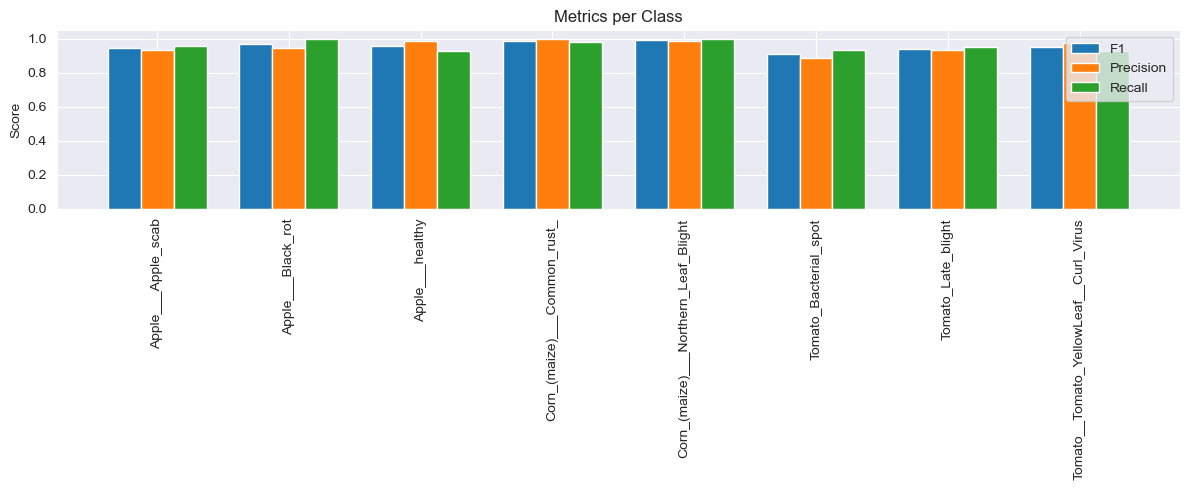

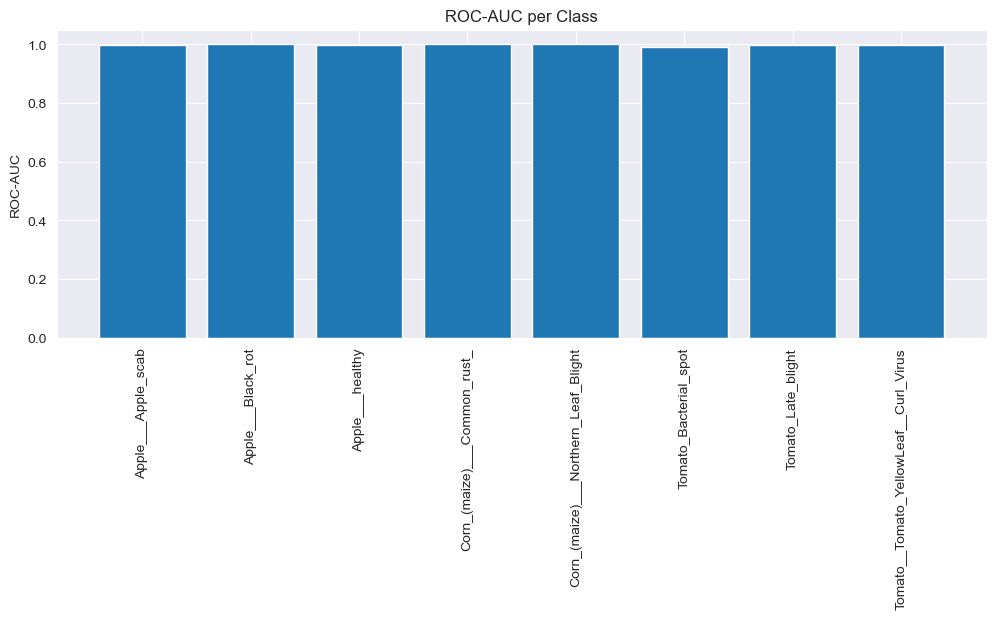

In [98]:
# -----------------------------
# METRICS VISUALIZATION
# -----------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

# collect all predictions and true labels from test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# compute metrics per class
f1_scores = f1_score(all_labels, all_preds, average=None)
precisions = precision_score(all_labels, all_preds, average=None)
recalls = recall_score(all_labels, all_preds, average=None)

# print metrics
print("F1-scores per class:", f1_scores)
print("Precision per class:", precisions)
print("Recall per class:", recalls)

# plot F1, Precision, Recall per class
plt.figure(figsize=(12,5))
x = np.arange(len(classes))
width = 0.25

plt.bar(x - width, f1_scores, width=width, label='F1')
plt.bar(x, precisions, width=width, label='Precision')
plt.bar(x + width, recalls, width=width, label='Recall')
plt.xticks(x, classes, rotation=90)
plt.ylabel("Score")
plt.title("Metrics per Class")
plt.legend()
plt.tight_layout()
plt.show()

# compute ROC-AUC per class
labels_bin = label_binarize(all_labels, classes=np.arange(len(classes)))
probs_all = []

with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        probs_all.append(probs.cpu().numpy())

probs_all = np.vstack(probs_all)

roc_aucs = []
for i in range(len(classes)):
    try:
        score = roc_auc_score(labels_bin[:, i], probs_all[:, i])
    except:
        score = np.nan
    roc_aucs.append(score)

# plot ROC-AUC per class
plt.figure(figsize=(12,4))
plt.bar(x, roc_aucs)
plt.xticks(x, classes, rotation=90)
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC per Class")
plt.show()
